In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [1]:
!nvidia-smi

Thu Jun  3 04:11:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
import pandas as pd 
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
import os
os.listdir('/content/drive/MyDrive/kaggle_dataset/Tomato/tomato_4_classes/val')

['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']

In [ ]:
os.listdir('/content/drive/MyDrive/kaggle_dataset/Tomato/tomato_4_classes/train')

['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Leaf_Mold']

In [ ]:
# re-size all the images to this
IMG_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Dataset/tomato_4_classes/train'
valid_path = '/content/drive/MyDrive/Dataset/tomato_4_classes/val'


# INCEPTION V3

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)




87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Dataset/tomato_4_classes/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:

# view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 4000 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 400 images belonging to 4 classes.


In [ ]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy',
                                              patience=3,
                                                 mode='max')

model.compile(loss='categorical_crossentropy', 
              optimizer= tf.keras.optimizers.Adam(learning_rate=lr_scheduler), 
             metrics = ['accuracy'])

history = model.fit(training_set, epochs = 10,
                    validation_data = test_set,                    
                    steps_per_epoch=len(training_set),
                    validation_steps=len(test_set),
                    callbacks=[early_stopping])

Epoch 1/10
63/63 [==============================] - 54s 771ms/step - loss: 22.3934 - accuracy: 0.7398 - val_loss: 10.3611 - val_accuracy: 0.8250
Epoch 2/10
63/63 [==============================] - 46s 732ms/step - loss: 3.8570 - accuracy: 0.9085 - val_loss: 4.7822 - val_accuracy: 0.8875
Epoch 3/10
63/63 [==============================] - 46s 731ms/step - loss: 2.2320 - accuracy: 0.9308 - val_loss: 5.5567 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 46s 725ms/step - loss: 1.4423 - accuracy: 0.9550 - val_loss: 5.6250 - val_accuracy: 0.8525
Epoch 5/10
63/63 [==============================] - 46s 728ms/step - loss: 4.7628 - accuracy: 0.9010 - val_loss: 3.6621 - val_accuracy: 0.9225
Epoch 6/10
63/63 [==============================] - 46s 729ms/step - loss: 1.5201 - accuracy: 0.9603 - val_loss: 3.4232 - val_accuracy: 0.9350
Epoch 7/10
63/63 [==============================] - 46s 723ms/step - loss: 1.0801 - accuracy: 0.9670 - val_loss: 2.8568 - val_accuracy: 0.93

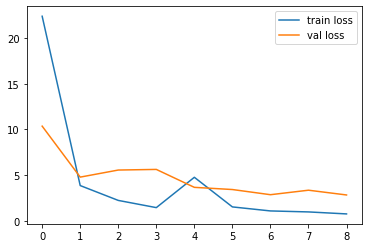

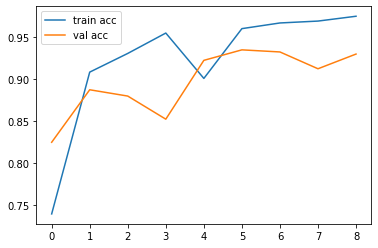

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('tomato_inceptionV3.h5')

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('tomato_inceptionV3.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("tomato_inceptionV3.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5dyya4yc/assets


INFO:tensorflow:Assets written to: /tmp/tmp5dyya4yc/assets


87947232

In [ ]:
%cd /content/

/content


In [ ]:
!ls

'1fa37cd4-066e-4deb-ab99-5fa8dcc4481c___RS_Late.B 5454.JPG'
 AccVal_acc.png
 drive
 LossVal_loss.png
 sample_data
'Tomato___healthy_original_1b966d62-d5c3-4a67-ba36-b67d873ccfdf___GH_HL Leaf 440.JPG_ecb750a6-f5a2-48cb-9152-21d88f8c9c54.JPG'
 tomato_inceptionV3.h5
 tomato_inceptionV3.tflite
'Tomato___Leaf_Mold_original_b625a517-f750-41d9-887d-61033eddbce9___Crnl_L.Mold 8890.JPG_c2dfd7e4-44e5-4826-a5a7-d732aad146c3.JPG'
'Tomato___Tomato_mosaic_virus_original_01b32f27-2b9b-4961-805b-8066bf4d90f1___PSU_CG 2417.JPG_d12017e3-aca4-49f1-b01c-8f4e418e6d5e.JPG'


In [ ]:
!mv tomato_inceptionV3.h5 '/content/drive/MyDrive/Deployment ML'

In [ ]:
!mv tomato_inceptionV3.tflite '/content/drive/MyDrive/Deployment ML'

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=x/255         
  x=np.expand_dims(x, axis=0)
  #images = np.vstack([x])
  x = preprocess_input(x)
  classes = model.predict(x, batch_size=10)
  print(classes)

Saving Tomato___healthy_original_1b966d62-d5c3-4a67-ba36-b67d873ccfdf___GH_HL Leaf 440.JPG_ecb750a6-f5a2-48cb-9152-21d88f8c9c54.JPG to Tomato___healthy_original_1b966d62-d5c3-4a67-ba36-b67d873ccfdf___GH_HL Leaf 440.JPG_ecb750a6-f5a2-48cb-9152-21d88f8c9c54 (1).JPG
Saving 1fa37cd4-066e-4deb-ab99-5fa8dcc4481c___RS_Late.B 5454.JPG to 1fa37cd4-066e-4deb-ab99-5fa8dcc4481c___RS_Late.B 5454 (1).JPG
Saving Tomato___Tomato_mosaic_virus_original_01b32f27-2b9b-4961-805b-8066bf4d90f1___PSU_CG 2417.JPG_d12017e3-aca4-49f1-b01c-8f4e418e6d5e.JPG to Tomato___Tomato_mosaic_virus_original_01b32f27-2b9b-4961-805b-8066bf4d90f1___PSU_CG 2417.JPG_d12017e3-aca4-49f1-b01c-8f4e418e6d5e (1).JPG
Saving Tomato___Leaf_Mold_original_b625a517-f750-41d9-887d-61033eddbce9___Crnl_L.Mold 8890.JPG_c2dfd7e4-44e5-4826-a5a7-d732aad146c3.JPG to Tomato___Leaf_Mold_original_b625a517-f750-41d9-887d-61033eddbce9___Crnl_L.Mold 8890.JPG_c2dfd7e4-44e5-4826-a5a7-d732aad146c3 (1).JPG
[[1.0000000e+00 2.4032046e-25 8.0389703e-15 1.409929